# Analyzing with iNNvestigate

**iNNvestigate** got created to make analyzing neural network's predictions easy! The library should help the user to focus on research and development by providing implemented analysis methods and facilitating rapid development of new methods. In this notebook we will show you how to use **iNNvestigate** and for a better understanding we recommend to read [iNNvestigate neural networks!](https://jmlr.org/papers/v20/18-540.html) first! How to use **iNNvestigate** you can read in this notebook: [Developing with iNNvestigate](introduction_development.ipynb)

-----

**The intention behind iNNvestigate is to make it easy to use analysis methods, but it is not to explain the underlying concepts and assumptions. Please, read the according publication(s) when using a certain method and when publishing please cite the according paper(s) (as well as the [iNNvestigate paper](https://jmlr.org/papers/v20/18-540.html)). Thank you!** You can find most related publication in [iNNvestigate neural networks!](https://jmlr.org/papers/v20/18-540.html) and in the README file.

### Analysis methods

The field of analyizing neural network's predictions is about gaining insights how and why a potentially complex network gave as output a certain value or choose a certain class over others. This is often called interpretability or explanation of neural networks. We just call it analyzing a neural network's prediction to be as neutral as possible and to leave any conclusions to the user.

Most methods have in common that they analyze the input features w.r.t. a specific neuron's output. Which insights a method reveals about this output can be grouped into (see [Learning how to explain: PatternNet and PatternAttribution](https://arxiv.org/abs/1705.05598)):

* **function:** analyzing the operations the network function uses to extract or compute the output. E.g., how would changing an input feature change the output.
* **signal:** analyzing the components of the input that cause the output. E.g., which parts of an input image or which directions of an input are used to determine the output.
* **attribution:** attributing the "importance" of input features for the output. E.g., how much would changing an input feature change the output.

----

In this notebook we will introduce methods for each of these categories and along show how to use different features of **iNNvestigate**, namely how to:

* analyze a prediction.
* train an analyzer.
* analyze a prediction w.r.t to a specific output neuron.

Let's dive right into it!

### Run on Colab
> Colab uses per default tensorflow 1.15 which was not used for development of `iNNvestigate`  
> Switch to colab GPU runtime for performance

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/albermax/innvestigate/blob/master/examples/notebooks/introduction.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>



In [ ]:
import os
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 1.x
    IS_COLAB = True
    if not os.path.exists('/content/innvestigate'):
        !git clone https://github.com/albermax/innvestigate.git
        !pip install /content/innvestigate --no-deps
    %cd /content/innvestigate/examples/notebooks
except Exception:
    IS_COLAB = False

TensorFlow 1.x selected.
/content/innvestigate/examples/notebooks



### Training a network

To analyze a network, we need a network! As a base for **iNNvestigate** we chose the Keras deep learning library, because it is easy to use and allows to inspect build models.

In this first piece of code we import all the necessary modules:

In [ ]:
import warnings
warnings.simplefilter('ignore')

In [ ]:
%matplotlib inline  

import imp
import matplotlib.pyplot as plot
import numpy as np
import os

import keras
import keras.backend
import keras.layers
import keras.models
import keras.utils

import innvestigate
import innvestigate.utils as iutils

# Use utility libraries to focus on relevant iNNvestigate routines.
mnistutils = imp.load_source("utils_mnist", "../utils_mnist.py")
eutils = imp.load_source("utils", "../utils.py")


In [ ]:
innvestigate.__version__

'1.0.9'

to load the data:

In [ ]:
# Load data
# returns x_train, y_train, x_test, y_test as numpy.ndarray
data_not_preprocessed = mnistutils.fetch_data()

# Create preprocessing functions
input_range = [-1, 1]
preprocess, revert_preprocessing = mnistutils.create_preprocessing_f(data_not_preprocessed[0], input_range)

# Preprocess data
data = (
    preprocess(data_not_preprocessed[0]), data_not_preprocessed[1],
    preprocess(data_not_preprocessed[2]), data_not_preprocessed[3]
)

num_classes = len(np.unique(data[1]))
label_to_class_name = [str(i) for i in range(num_classes)]

and to now create and train a CNN model:

In [ ]:
# Create & train model
if keras.backend.image_data_format == "channels_first":
    input_shape = (1, 28, 28)
else:
    input_shape = (28, 28, 1)

model = keras.models.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation="relu", input_shape=input_shape),
    keras.layers.Conv2D(64, (3, 3), activation="relu"),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation="relu"),
    keras.layers.Dense(10, activation="softmax"),
])

scores = mnistutils.train_model(model, data, batch_size=128, epochs=3)
print("Scores on test set: loss=%s accuracy=%s" % tuple(scores))

Epoch 1/3
60000/60000 [==============================] - 186s 3ms/step - loss: 0.1238 - accuracy: 0.9617
Epoch 2/3
60000/60000 [==============================] - 190s 3ms/step - loss: 0.0355 - accuracy: 0.9885
Epoch 3/3
60000/60000 [==============================] - 189s 3ms/step - loss: 0.0193 - accuracy: 0.9937
Scores on test set: loss=0.02639943518221844 accuracy=0.9909999966621399


## Analyzing a predicition

In this first part we show how to create and use an analyzer. To do so we use an analyzer from *function* category, namely the gradient. The gradient shows how the linearized network function reacts on changes of a single feature.

This is simply done by passing the model without a softmax to the analyzer class:

In [ ]:
# Scale to [0, 1] range for plotting.
def input_postprocessing(X):
    return revert_preprocessing(X) / 255

# Configure analysis methods and properties
methods = [
    # NAME                    OPT.PARAMS                POSTPROC FXN               TITLE

    # Show input
    ("input",                 {},                       input_postprocessing,      "Input"),
    ("lrp.z",                 {},                       mnistutils.heatmap,        "LRP-Z"),
    ("lrp.epsilon",           {"epsilon": 1},           mnistutils.heatmap,        "LRP-Epsilon")
]

# Create model without trailing softmax
model_wo_softmax = iutils.keras.graph.model_wo_softmax(model)

# Create analyzers.
analyzers = []
for method in methods:
    analyzer = innvestigate.create_analyzer(method[0],        # analysis method identifier
                                            model_wo_softmax, # model without softmax output
                                            **method[1])      # optional analysis parameters
    # Some analyzers require training.
    analyzer.fit(data[0], batch_size=256, verbose=1)
    analyzers.append(analyzer)

Now we analyze each image with the different LRP analyzers:

In [ ]:
%%capture

n = 10
test_images = list(zip(data[2][:n], data[3][:n]))

analysis = np.zeros([len(test_images), len(analyzers), 28, 28, 3])
text = []


for i, (x, y) in enumerate(test_images):
    # Add batch axis.
    x = x[None, :, :, :]
    
    # Predict final activations, probabilites, and label.
    presm = model_wo_softmax.predict_on_batch(x)[0]
    prob = model.predict_on_batch(x)[0]
    y_hat = prob.argmax()
    
    # Save prediction info:
    text.append(("%s" % label_to_class_name[y],    # ground truth label
                 "%.2f" % presm.max(),             # pre-softmax logits
                 "%.2f" % prob.max(),              # probabilistic softmax output  
                 "%s" % label_to_class_name[y_hat] # predicted label
                ))

    for aidx, analyzer in enumerate(analyzers):
        # Analyze.
        a = analyzer.analyze(x)
        
        # Apply common postprocessing, e.g., re-ordering the channels for plotting.
        a = mnistutils.postprocess(a)
        # Apply analysis postprocessing, e.g., creating a heatmap.
        a = methods[aidx][2](a)
        # Store the analysis.
        analysis[i, aidx] = a[0]

Next, we visualize the analysis results:


<Figure size 432x288 with 0 Axes>

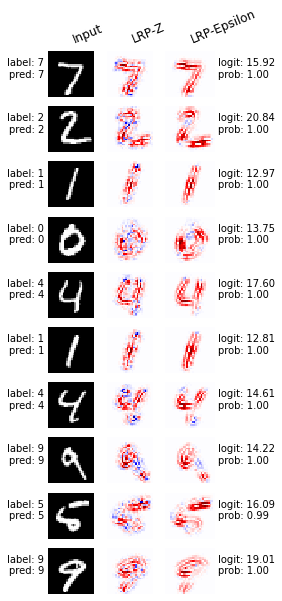

In [ ]:
# Prepare the grid as rectengular list
grid = [[analysis[i, j] for j in range(analysis.shape[1])]
        for i in range(analysis.shape[0])]
# Prepare the labels
label, presm, prob, pred = zip(*text)
row_labels_left = [('label: {}'.format(label[i]), 'pred: {}'.format(pred[i])) for i in range(len(label))]
row_labels_right = [('logit: {}'.format(presm[i]), 'prob: {}'.format(prob[i])) for i in range(len(label))]
col_labels = [''.join(method[3]) for method in methods]

# Plot the analysis.
eutils.plot_image_grid(grid, row_labels_left, row_labels_right, col_labels,
                       file_name=os.environ.get("PLOTFILENAME", None))

Each column shows the visualized results for different analyzers and each row shows the analyses w.r.t. to one input sample. To the left of each row, the ground truth label label and the predicted label pred are show. To the right, the model's probabilistic (softmax) output is shown as prob and the logit output just before the terminating softmax layer as logit. Note that all analyses have been performed based on the logit output (layer).

This figure shows the analysis w.r.t. to most activated neuron, e.g., actually predicted class. To see how to analyze the prediction w.r.t. to other neurons/classes have a look here: Analyzing different classes with MNIST

